In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
symbol='^NSEI'
start_date='01-04-2023'
end_date='31-03-2024'

In [3]:
ticker=yf.Ticker(symbol)
info=ticker.info
name=info['longName']

In [4]:
start_date_without_std_format=start_date
start_date=start_date.split('-')
start_date=start_date[::-1]
start_date='-'.join(start_date)

end_date_without_std_format=end_date
end_date=end_date.split('-')
end_date=end_date[::-1]
end_date='-'.join(end_date)

In [5]:
data=yf.download(symbol, start=start_date, end=end_date)
data.to_csv(f'{symbol}_historical_data')
data.reset_index(inplace=True)
df=pd.DataFrame(data[['Date','Adj Close']])
print(df)

[*********************100%%**********************]  1 of 1 completed

          Date     Adj Close
0   2023-04-03  17398.050781
1   2023-04-05  17557.050781
2   2023-04-06  17599.150391
3   2023-04-10  17624.050781
4   2023-04-11  17722.300781
..         ...           ...
238 2024-03-21  22011.949219
239 2024-03-22  22096.750000
240 2024-03-26  22004.699219
241 2024-03-27  22123.650391
242 2024-03-28  22326.900391

[243 rows x 2 columns]


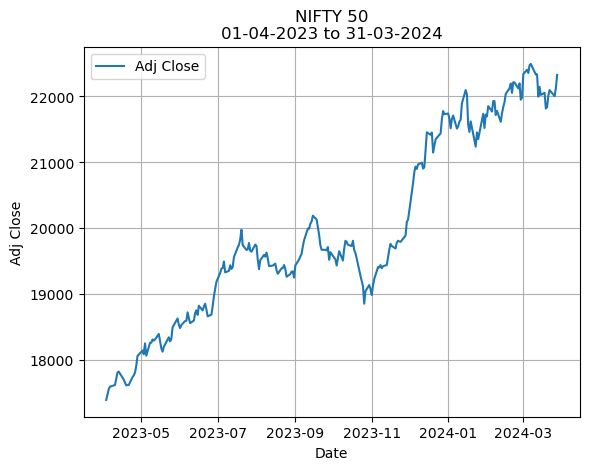

In [6]:
plt.plot(df['Date'], df['Adj Close'], label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title(f'{name}\n{start_date_without_std_format} to {end_date_without_std_format}')
plt.legend()
plt.grid()

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Adj Close']])

# Splitting data into input and output
X_rnn, y_rnn = [], []
time_step = 30
for i in range(len(scaled_data) - time_step):
    X_rnn.append(scaled_data[i:(i + time_step), 0])
    y_rnn.append(scaled_data[i + time_step, 0])
X_rnn, y_rnn = np.array(X_rnn), np.array(y_rnn)

# Reshape input to be [samples, time steps, features]
X_rnn = np.reshape(X_rnn, (X_rnn.shape[0], X_rnn.shape[1], 1))

# Splitting data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_rnn, y_rnn, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_rnn.shape[1], 1)),
    LSTM(units=50),
    Dense(units=1)
])

In [8]:
# # List of optimizers and loss functions to experiment with
# optimizers = ['rmsprop', 'adam', 'adadelta', 'adamax']
# loss_functions = ['mean_squared_error', 'huber_loss', 'logcosh']

# # Iterate over optimizers and loss functions
# for optimizer in optimizers:
#     for loss_function in loss_functions:
#         # Compile the model with current optimizer and loss function
#         model.compile(optimizer=optimizer, loss=loss_function)
        
#         # Train the model
#         history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val), verbose=0)

#         # Calculate evaluation metrics on validation set
#         y_val_pred = model.predict(X_val)
#         y_val_pred_inv = scaler.inverse_transform(y_val_pred)
#         y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

#         mae_val = mean_absolute_error(y_val_inv, y_val_pred_inv)
#         mse_val = mean_squared_error(y_val_inv, y_val_pred_inv)
#         rmse_val = np.sqrt(mse_val)

#         print(f"Validation Set Metrics, optimizer={optimizer} loss={loss_function}")
#         print("Mean Absolute Error:", mae_val)
#         print("Mean Squared Error:", mse_val)
#         print("Root Mean Squared Error:", rmse_val)

#         # Calculate R^2 score
#         r2 = r2_score(y_val_inv, y_val_pred_inv)
#         print("R^2 Score:", r2)

In [17]:
#Use suitable combination of optimizer and loss
#model.compile(optimizer='rmsprop', loss='logcosh')
#model.compile(optimizer='adamax', loss='logcosh')
model.compile(optimizer='adamax', loss='huber_loss')
        
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val), verbose=0)

# Calculate evaluation metrics on validation set
y_val_pred = model.predict(X_val)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

mae_val = mean_absolute_error(y_val_inv, y_val_pred_inv)
mse_val = mean_squared_error(y_val_inv, y_val_pred_inv)
rmse_val = np.sqrt(mse_val)

print(f"Validation Set Metrics:")
print("Mean Absolute Error:", mae_val)
print("Mean Squared Error:", mse_val)
print("Root Mean Squared Error:", rmse_val)

# Calculate R^2 score
r2 = r2_score(y_val_inv, y_val_pred_inv)
print("R^2 Score:", r2)

1/1 [==============================] - 3s 3s/step
Validation Set Metrics:
Mean Absolute Error: 135.61476934523827
Mean Squared Error: 25527.387783595426
Root Mean Squared Error: 159.77292569016637
R^2 Score: 0.9862212050117406


In [18]:
# Extend the prediction horizon
future_time_steps = 60
X_future = scaled_data[-time_step:]
X_future = np.array([X_future[i:i+time_step, 0] for i in range(len(X_future) - time_step + 1)])
X_future = X_future.reshape(X_future.shape[0], X_future.shape[1], 1)

# Predict future values
future_predictions = []
current_input = X_future[0].reshape(1, X_future.shape[1], 1)
for i in range(future_time_steps):
    future_prediction = model.predict(current_input)
    future_predictions.append(future_prediction[0, 0])
    current_input = np.append(current_input[:, 1:, :], future_prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 75ms/step


In [19]:
# Create a DataFrame for future predictions
predicted_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_time_steps + 1, closed='right')
predicted_prices_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Price': future_predictions.flatten()})

# Print the DataFrame
print(predicted_prices_df)

         Date  Predicted Price
0  2024-03-29     22260.677734
1  2024-03-30     22273.902344
2  2024-03-31     22226.078125
3  2024-04-01     22164.246094
4  2024-04-02     22104.794922
5  2024-04-03     22058.917969
6  2024-04-04     22033.060547
7  2024-04-05     22028.072266
8  2024-04-06     22040.353516
9  2024-04-07     22063.542969
10 2024-04-08     22090.386719
11 2024-04-09     22114.240234
12 2024-04-10     22130.392578
13 2024-04-11     22136.546875
14 2024-04-12     22132.960938
15 2024-04-13     22121.927734
16 2024-04-14     22106.835938
17 2024-04-15     22091.298828
18 2024-04-16     22078.316406
19 2024-04-17     22069.712891
20 2024-04-18     22066.062500
21 2024-04-19     22066.783203
22 2024-04-20     22070.539062
23 2024-04-21     22075.658203
24 2024-04-22     22080.552734
25 2024-04-23     22084.001953
26 2024-04-24     22085.335938
27 2024-04-25     22084.470703
28 2024-04-26     22081.812500
29 2024-04-27     22078.035156
30 2024-04-28     22073.908203
31 2024-

C:\Users\admin\AppData\Local\Temp\ipykernel_12636\2301246188.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_time_steps + 1, closed='right')


C:\Users\admin\AppData\Local\Temp\ipykernel_12636\757308646.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  plt.plot(pd.date_range(start=df['Date'].iloc[-1], periods=future_time_steps + 1, closed='right'), future_predictions, color='red', label='Predicted')


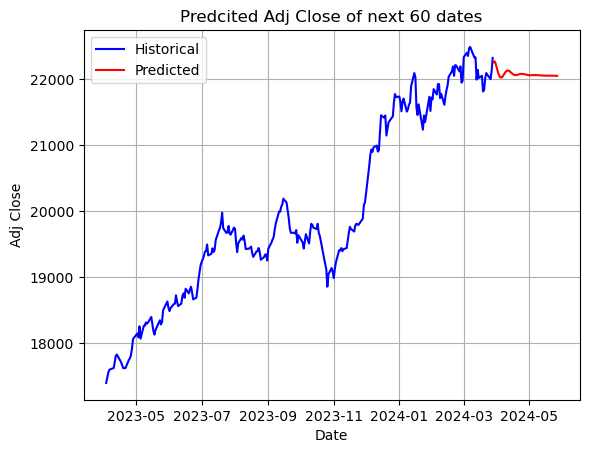

In [20]:
# Plotting
plt.plot(df['Date'], scaler.inverse_transform(scaled_data), color='blue', label='Historical')
plt.plot(pd.date_range(start=df['Date'].iloc[-1], periods=future_time_steps + 1, closed='right'), future_predictions, color='red', label='Predicted')
plt.title(f'Predcited Adj Close of next {future_time_steps} dates')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid()
plt.show()